# DM : Redimensionnement d'image par *Seam Carving*

[Ce DM est à effectuer sur Capytale (cliquer ici)](https://capytale2.ac-paris.fr/web/c/ac7d-2158258).
Il faut se connecter avec " Ma Classe en Région (Auvergne-Rhône-Alpes)" en utilisant ses identifiants ENT.
Si vous n'avez pas vos identifiants ENT, vous pouvez utiliser Basthon en [téléchargeant l'image (ici)](https://raw.githubusercontent.com/fortierq/cours/main/algo/prog_dyn/seam_carving/tower.png) puis en la chargeant sur Basthon avec Fichier -> Ouvrir...

> L'objectif est de redimensionner une image par la méthode de [*Seam Carving*](https://faculty.runi.ac.il/arik/scweb/imret/imret.pdf). Cette technique consiste à supprimer des chemins d'énergie minimale sur l'image, c'est-à-dire utilisant des pixels de couleurs relativement uniformes. Ainsi, on évite de trop modifier l'image.

<figure>
<center>
<img src=https://raw.githubusercontent.com/fortierq/cours/main/algo/prog_dyn/seam_carving/tower.png height=200><br>
    Image que l'on souhaite redimensionner
</center>
</figure>

<center>    
    <img src=https://raw.githubusercontent.com/fortierq/cours/main/algo/prog_dyn/seam_carving/resize.png height=200><br>
    Redimensionnement classique, l'image est déformée.<br><br>
    <img src=https://raw.githubusercontent.com/fortierq/cours/main/algo/prog_dyn/seam_carving/path.png height=200><br>
    Redimensionnement par seam carving, un chemin d'énergie minimale étant représenté en rouge.
</center>

## Chargement de l'image

Commençons par charger l'image :

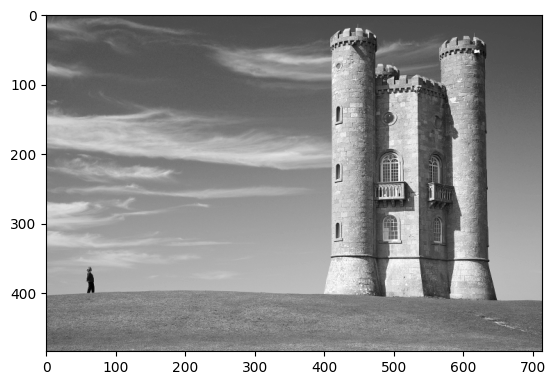

In [1]:
import matplotlib.pyplot as plt
import numpy as np

m = plt.imread('tower.png')
plt.imshow(m, cmap='gray') # affiche l'image
plt.show()

La variable `m` que nous venons de définir contient alors une matrice `numpy` qui représente l'image. Comme l'image est en niveau de gris, chaque pixel est représenté par un nombre flottant (`float`) entre 0 (noir) et 1 (blanc).

In [2]:
print("valeur du pixel en haut à gauche :", m[0][0])
print("nombre de lignes :", len(m))
print("nombre de colonnes :", len(m[0]))
print("dimensions de l'image :", np.shape(m)) # une autre façon possible avec une matrice numpy

valeur du pixel en haut à gauche : 0.28627452
nombre de lignes : 484
nombre de colonnes : 714
dimensions de l'image : (484, 714)


## Calcul de gradient

On définit une matrice $g = (g_{i, j})$ de même dimension que $m$ telle que :

$$g_{i, j} = |m_{i + 1, j} - m_{i - 1, j}| + |m_{i, j + 1} - m_{i, j - 1}|$$

La formule ci-dessus n'étant pas valable pour la première/dernière ligne ($i = 0$ ou $i = n - 1$, où $n$ est le nombre de lignes de $m$), on utilise à la place :  

$$g_{0, j} = |m_{1, j} - m_{0, j}| + |m_{i, j + 1} - m_{i, j - 1}|$$

$$g_{n - 1, j} = |m_{n - 1, j} - m_{n - 2, j}| + |m_{i, j + 1} - m_{i, j - 1}|$$

Et de même sur la première/dernière colonne.

Intuitivement, $g_{i, j}$ correspond à l'intensité du gradient de l'image sur le pixel $i, j$ : plus il est grand, plus il y a de fortes variation de couleur au niveau de ce pixel.

````{admonition} Question
 Écrire une fonction `matrice_gradient(m)` qui renvoie `g` à partir de `m`. On pourra utiliser, au choix, une liste de listes ou un tableau `numpy` (en utilisant, par exemple, `np.zeros((..., ...))` pour créer `g`). On pourra utiliser `abs` pour la valeur absolue.
````

````{admonition} Solution
:class: tip, dropdown
``` python
def matrice_gradient(m):
    n, k = np.shape(m)
    g = np.zeros((n, k))
    g[0][0] = abs(m[1][0] - m[0][0]) + abs(m[0][1] - m[0][0])
    g[n-1][k-1] = abs(m[n-1][k-1] - m[n-2][k-1]) + abs(m[n-1][k-1] - m[n-1][k-2])
    g[0][k-1] = abs(m[1][k-1] - m[0][k-1]) + abs(m[0][k-1] - m[0][k-2])
    g[n-1][0] = abs(m[n-1][0] - m[n-2][0]) + abs(m[n-1][1] - m[n-1][0])
    for i in range(1, n-1):
        g[i][0] = abs(m[i+1][0] - m[i-1][0]) + abs(m[i][1] - m[i][0])
        g[i][k-1] = abs(m[i+1][k-1] - m[i-1][k-1]) + abs(m[i][k-1] - m[i][k-2])
    for j in range(1, k-1):
        g[0][j] = abs(m[1][j] - m[0][j]) + abs(m[0][j+1] - m[0][j-1])
        g[n-1][j] = abs(m[n-1][j] - m[n-2][j]) + abs(m[n-1][j+1] - m[n-1][j-1])
    for i in range(1, n-1):
        for j in range(1, k-1):
            g[i][j] = abs(m[i+1][j] - m[i-1][j]) + abs(m[i][j+1] - m[i][j-1])
    return g
```
````

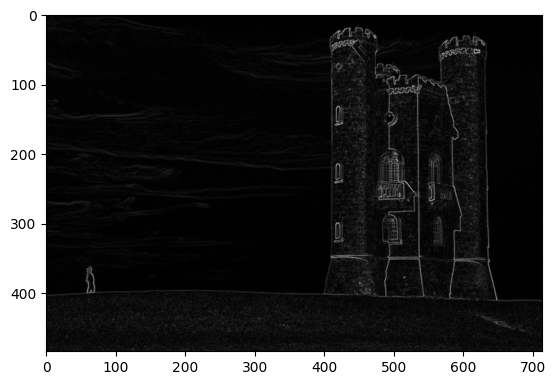

In [4]:
g = matrice_gradient(m)
plt.imshow(g, cmap='gray') # affichage pour vérifier
plt.show()

Dans la suite, on pourra utiliser la fonction suivante qui sera plus rapide, *a priori* :

In [5]:
def matrice_gradient(m):
    g = np.zeros_like(m)
    g[1:-1] = np.abs(m[2:] - m[:-2])
    g[0] = np.abs(m[1] - m[0])
    g[-1] = np.abs(m[-1] - m[-2])
    g[:, 1:-1] += np.abs(m[:, 2:] - m[:, :-2])
    g[:, 0] += np.abs(m[:, 1] - m[:, 0])
    g[:, -1] += np.abs(m[:, -1] - m[:, -2])
    return g

## Enlever un chemin

Nous enlèverons seulement des chemins verticaux. Un chemin sera donné par une liste `c` contenant les pixels `m[i][c[i]]`. Par exemple, si `c = [231, 230, 231...]` alors `c` passe par le pixel `m[0][231]`, puis `m[1][230]`, `m[2][231]`...

````{admonition} Question
 Écrire une fonction `enlever_chemin` telle que, si `m` est une image de taille $n\times p$, `enlever_chemin(m, c)` renvoie une matrice `m2` de taille $n\times (p - 1)$ obtenue à partir de `m` en supprimant chaque pixel du chemin `c`. On pourra compléter le code suivant :
````

In [6]:
def enlever_chemin(m, c):
    n, p = np.shape(m) # n est le nombre de lignes, p le nombre de colonnes
    m2 = [] # définition de m2 comme liste de listes
    for i in range(n):
        l = [] # ième ligne de m2
        for j in range(p):
            ... # ajouter la ligne m[i] sauf m[i][c[i]]
        ... # ajouter la ligne l à m2
    return np.array(m2) # conversion en matrice numpy

````{admonition} Solution
:class: tip, dropdown
``` python
def enlever_chemin(m, c):
    n, p = np.shape(m)
    m2 = []
    for i in range(n):
        l = []
        for j in range(p):
            if j != c[i]:
                l.append(m[i][j])
        m2.append(l)
    return np.array(m2)
```
````

## Calcul d'un chemin d'énergie minimum par programmation dynamique

On ne considère que les chemins verticaux.  
L'**énergie d'un chemin** est définie comme la somme des gradients ($g_{i, j}$) des pixels du chemin.  
Soit $d_{i, j}$ l'énergie minimum d'un chemin depuis le haut de l'image jusqu'à un pixel $i, j$.  
Pour atteindre le pixel $i, j$, on peut soit passer par le pixel $i - 1, j - 1$, soit $i - 1, j$ ou $i - 1, j + 1$.  
On a donc :

$$d_{i, j} = \min(d_{i - 1, j - 1}, d_{i - 1, j}, d_{i - 1, j + 1}) + g_{i, j}$$
$$d_{0, j} = g_{0, j}$$

Remarque : attention à ne pas dépasser les bords de l'image (on ne prend pas en compte le pixel $i - 1, j - 1$ si $j = 0$, par exemple).

````{admonition} Question
 Écrire une fonction `dp_chemin(g)` qui renvoie une matrice `d` de même dimension que `g` telle que `d[i][j]` est l'énergie minimum d'un chemin depuis le haut de l'image jusqu'à un pixel `i, j`.
````

````{admonition} Solution
:class: tip, dropdown
``` python
def dp_chemin(g):
    d = np.zeros(g.shape)
    d[0] = g[0]
    for i in range(1, g.shape[0]):
        d[i, 0] = g[i, 0] + min(d[i-1, 0], d[i-1, 1])
        d[i, -1] = g[i, -1] + min(d[i-1, -1], d[i-1, -2])
        for j in range(1, g.shape[1]-1):
            d[i, j] = g[i, j] + min(d[i-1, j-1], d[i-1, j], d[i-1, j+1])
    return d
```
````

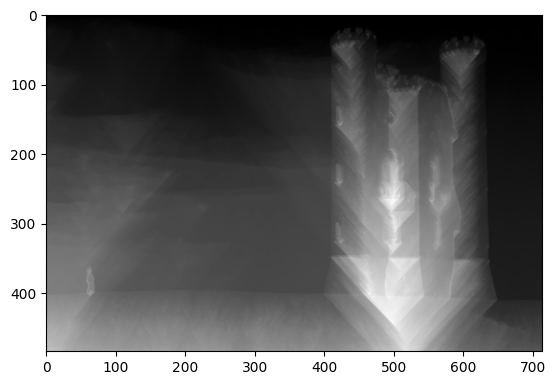

In [9]:
d = dp_chemin(matrice_gradient(m))
plt.imshow(d, cmap='gray') # affichage de d : plus un pixel est sombre, plus il est facile de le supprimer
plt.show()

On veut maintenant trouver un chemin vertical d'énergie minimum à partir de la matrice `d` de la question précédente.  
Pour cela, on construit le chemin à l'envers : on commence par chercher le pixel de la dernière ligne (tout en bas) d'énergie minimale, puis on remonte.

````{admonition} Question
 Écrire une fonction `min_energie_bas(d)` qui renvoie le numéro de colonne `j` du pixel de la dernière ligne d'énergie minimale, c'est-à-dire tel que `d[n - 1][j]` est minimal, où `d` est la matrice renvoyée par la fonction `dp_chemin(m)` et `n` est le nombre de lignes de `d`.
````

````{admonition} Solution
:class: tip, dropdown
``` python
def min_energie_bas(d):
    j_mini = 0 # indice du minimum de d sur la dernière ligne
    for j in range(1, d.shape[1]):
        if d[-1, j] < d[-1, j_mini]:
            j_mini = j
    return j_mini
```
````

In [11]:
min_energie_bas(d)

705

````{admonition} Question
 Écrire une fonction `min_chemin(m)` qui renvoie un chemin `c` vertical d'énergie minimum dans une image `m`. Ainsi, `c[i]` est le numéro de colonne du pixel de la ligne `i` du chemin. `d` est la matrice renvoyée par la fonction `dp_chemin(m)`. 
````

In [12]:
def min_chemin(m):
    d = dp_chemin(matrice_gradient(m))
    c = [min_energie_bas(d)]
    for i in range(len(m) - 2, -1, -1): # parcours de la dernière ligne à la première
        j = c[-1] # position du chemin sur la ligne i+1
        mini = ... 
        ... # trouver le minimum de d[i, j-1], d[i, j], d[i, j+1]
        c.append(mini)
    return c[::-1] # pour inverser c

````{admonition} Solution
:class: tip, dropdown
``` python
def min_chemin(m):
    d = dp_chemin(matrice_gradient(m))
    c = [min_energie_bas(d)]
    for i in range(len(m) - 2, -1, -1):
        j = c[-1]
        mini = j
        for k in range(j - 1, j + 2):
            if k >= 0 and k < len(d[i]) and d[i, k] < d[i, j]:
                mini = k
        c.append(mini)
    return c[::-1] # pour inverser c
```
````

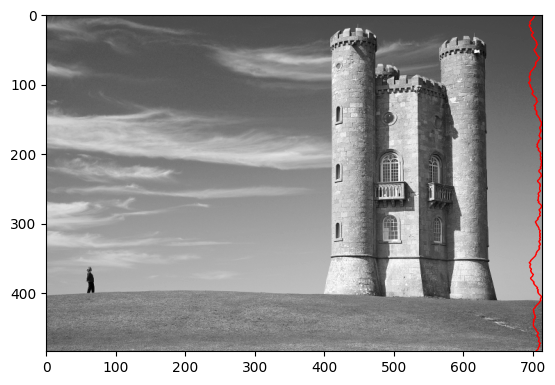

[702, 702, 702, 701, 701, 700, 699, 698, 697, 696]

In [14]:
c = min_chemin(m)
plt.imshow(m, cmap='gray')
plt.plot(c, range(len(c)), 'r', linewidth=1); # affichage de l'image avec le chemin en rouge
plt.show()
c[:10] # affichage des 10 premières valeurs de c

````{admonition} Question
 Écrire finalement une fonction `seam_carving(m, n)` qui réalise $n$ fois les instructions suivantes :  
- Calculer la matrice `g` des gradients de `m`
- Calculer un chemin `c` d'énergie minimum dans `g`  
- Enlever le chemin `c` de `m`
````

````{admonition} Solution
:class: tip, dropdown
``` python
def seam_carving(m, n):
    for i in range(n):
        c = min_chemin(m)
        m = enlever_chemin(m, c)
    return m
```
````

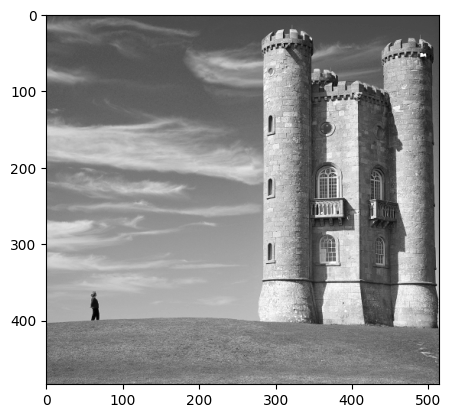

(484, 514)

In [16]:
seam_carving_im = seam_carving(m, 200) # on enlève 200 colonnes (cela prend un peu de temps)
plt.imshow(seam_carving_im, cmap='gray')
plt.show()
np.shape(seam_carving_im) # l'image a bien été redimensionnée

## Bonus

````{admonition} Question
 Modifier les fonctions précédentes pour redimensionner suivant la hauteur et non la largeur.
````

````{admonition} Question
 Tester avec l'image de votre choix.
````